### IMPORT DEPENDENCIES AND LIBRARY METHODS AND CLASSES

In [1]:
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from models.MLP import MLP0, MLP1, MLP2
from util import create_dataloaders, seed_everything, \
    train, test, preprocess_dataset, MultiTransforms, \
    TransformPCA, SatelliteDataset
import argparse

In [2]:
seed_everything(42)
IN_DIMS = 36
OUT_DIMS = 6 # label 6 has zero items so 6 classes only
DEVICE = "cuda:0"
ROOT_DIR = "dataset"

### DATASET CREATION, PREPROCESSING AND DATALOADERS 

In [3]:
train_dataset = SatelliteDataset("./dataset", train=True)
test_dataset = SatelliteDataset("./dataset", train=False)

# mean center and normalize
transform, target_transform = preprocess_dataset(train_dataset)

train_dataset.transform = transform
train_dataset.target_transform = target_transform

test_dataset.transform = transform
test_dataset.target_transform = target_transform

# create dataloaders of batch size 32
train_loader, test_loader = create_dataloaders(train_dataset, test_dataset,
                                               shuffle=True, batch_size=32)

In [4]:
def fit(
    model: nn.Module,
    train_loader,
    test_loader,
    args,
):
    train_loss = []
    train_accuracies = []

    test_loss = []
    test_accuracies = []

    early_stop_count = 0
    early_stop_patience = 5
    early_stop_tol = 5e-3

    progress_bar = tqdm(range(args.max_epochs), desc="Epochs")

    for i in progress_bar:
        loss, train_acc = train(model, train_loader,
                                lr=args.lr, device=args.device)
        loss = np.mean(loss)
        train_loss.append(loss)
        train_accuracies.append(train_acc)

        if args.verbose and i % args.log_freq == 0:
            
            progress_dict = {
                "loss": loss,
            }

            if i % args.test_freq == 0:
                results = test(model, test_loader,
                               device=args.device, metrics=["Accuracy", "Loss"])
                acc = results["Accuracy"]
                test_loss.append(results["Loss"])
                test_accuracies.append(acc)
                progress_dict["test_acc"] = acc
            progress_bar.set_postfix(progress_dict)

        if len(train_loss) > 1 and abs(loss-train_loss[-2]) < early_stop_tol:
            early_stop_count += 1
            if (early_stop_count >= early_stop_patience):
                print(f"Early stopping after {i} epochs.")
                break
        else:
            early_stop_count = 0

    if args.plot is True:
        # plot loss and accuracy in same plot
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].plot(train_loss, label="train")
        ax[0].plot(test_loss, label="test")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")

        ax[1].plot(train_accuracies, label="train")
        ax[1].plot(test_accuracies, label="test")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy")

        ax[0].legend()
        ax[1].legend()  
        plt.show()


    train_acc = test(model, train_loader, args.device)["Accuracy"]
    test_acc = test(model, test_loader, args.device)["Accuracy"]

    return train_acc, test_acc


## Results for model architecture:
1. 0 hidden layers
2. sigmoid activation function
3. input_dim = 36, output_dim = 6

Epochs: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s, loss=0.603, test_acc=0.831]


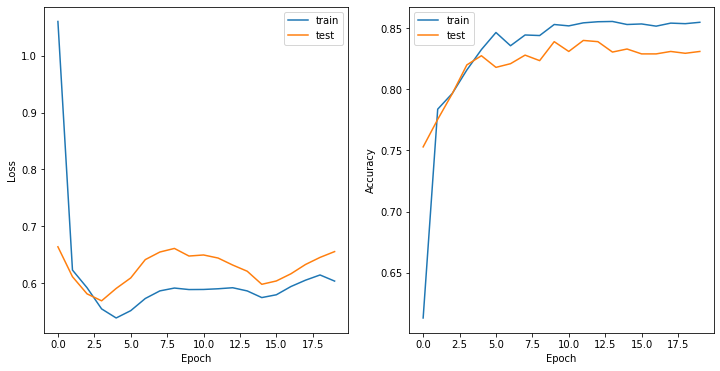

Final train accuracy: 0.8552097428958051
Final test accuracy: 0.8309154577288644


In [8]:
model = MLP0(IN_DIMS, OUT_DIMS).to(DEVICE)
lrs = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

args = argparse.Namespace(max_epochs=20, lr=1e-3, device=DEVICE,
                        verbose=True, log_freq=1, test_freq=1,plot=True)

train_acc, test_acc = fit(model, train_loader, test_loader, args)
print(f"Final train accuracy: {train_acc}")
print(f"Final test accuracy: {test_acc}")

0.8495714930085702 0.8194097048524263


In [ ]:
pca = PCA(n_components=2)
pca.fit(train_dataset.data)
pca_transform = TransformPCA(pca)
transforms = MultiTransforms([mtransform, pca_transform])

train_dataset.transform = transforms
train_dataset.target_transform = mtarget_transform